<a href="https://colab.research.google.com/github/pireylow/stock-price-prediction-LSTM-ARIMA/blob/main/ARIMA_First_Test_(Explanation%2BNegative_Example).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
!pip install yfinance

In [53]:
#import necessary modules
import random
import numpy as np

import yfinance as yf
yf.pdr_override()

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import pandas as pd
from pandas_datareader import data as pdr
from pandas.plotting import lag_plot

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [54]:
from numpy.lib.function_base import diff

#set stock information
ticker = 'SPY'
startdate = '2022-01-01'
enddate = '2023-01-01'

start = pd.to_datetime(startdate)
end = pd.to_datetime(enddate)
df = pdr.get_data_yahoo(ticker, start=start, end=end)

columnsTitles=['Open','High','Low','Close','Volume','Adj Close']
df=df.reindex(columns=columnsTitles)

close=df['Close']


[*********************100%***********************]  1 of 1 completed


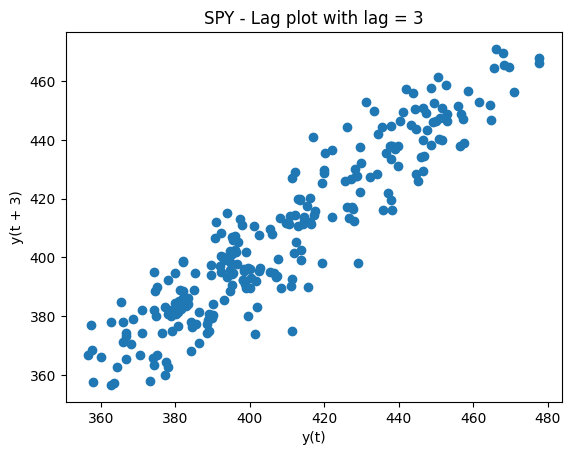

In [55]:
plt.figure()
lag_plot(close, lag=3)
plt.title(ticker + ' - Lag plot with lag = 3')
plt.show()

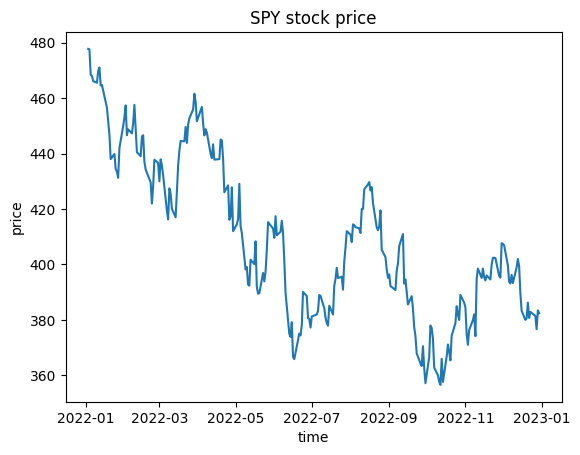

In [56]:
plt.plot(df["Close"])
plt.title(ticker + " stock price")
plt.xlabel("time")
plt.ylabel("price")
plt.show()

In [57]:
#Rolling out-of-sample forecast from an ARIMA Model
#train model using first 70% of data, last 30% for testing
#train_data, test_data = df[0:1200], df[1200:]
train_data, test_data = df[0:int(len(df)*0.7)], df[int(len(df)*0.7):]
training_data = train_data['Close'].values
testing_data = test_data['Close'].values

#create a list of past values (including training data -- true test value will be added one by one)
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(testing_data)

#loop over every data point for testing data
for time_point in range(N_test_observations):
    #create the arima model with order parameters being (order (number of time lags) of the auto-regressive model, number of times differentiated, MA value)
    model = ARIMA(history, order=(4,1,0))  #research questions about p,d,q parameters
    model_fit = model.fit()
    #forecast only one data point and output changes every loop
    output = model_fit.forecast()
    #first element of output is the forecasted value (forecast returns forecasted value, standard deviation and lower and upper bound)
    yhat = output[0]
    #create lists of predicted values and actual values
    model_predictions.append(yhat)
    true_test_value = testing_data[time_point]
    #add in new actual value each day after each loop to fit into the model
    history.append(true_test_value)   #research questions about size of the history window
MSE_error = mean_squared_error(testing_data, model_predictions)
print('Mean Squared Error For the Test Data: {}'.format(MSE_error))

Mean Squared Error For the Test Data: 34.06861544755335


In [58]:
print(yhat)

383.8503657031054


In [59]:
print(output)

[383.8503657]


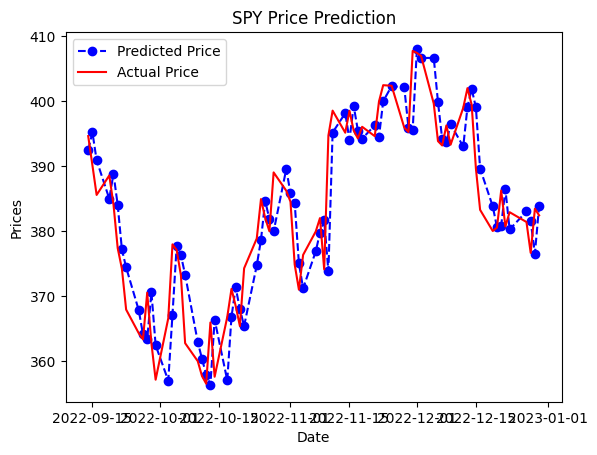

In [60]:
#test_set_range = df[1200:].index
test_set_range = df[int(len(df)*0.7):].index
plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
#plt.plot(test_set_range, model_predictions, color='blue',label='Predicted Price')
plt.plot(test_set_range, testing_data, color='red', label='Actual Price')
plt.title(ticker + ' Price Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()

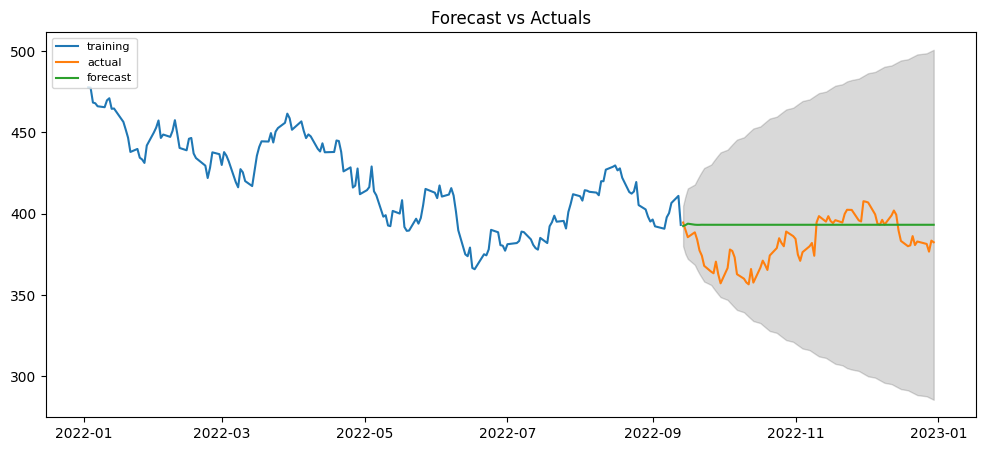

In [61]:
#the following is wrong way (but still regularly reported) since we want perform a rolling out-of-sample forecast
#The forecast method gives only point forecasts.

# Build Model
model = ARIMA(training_data, order=(4, 1, 0))
fitted = model.fit()

# Forecast where fc is the forecasted value, se is the standard error, conf is the lower and upper bound
#confidence intervals for the forecasts are (1 - alpha) % -- confidence level is 0.95
#confidence interval means percentage accuracy that actual value is withing the lower and upper bound

# Get the forecast object
forecast = fitted.get_forecast(steps=N_test_observations, alpha=0.05)

# Extract the forecasted values
fc = forecast.predicted_mean

# Extract the confidence intervals
conf = forecast.conf_int(alpha=0.05)


# Make as pandas series
fc_series = pd.Series(fc, index=test_data['Close'].index)
lower_series = pd.Series(conf[:, 0], index=test_data['Close'].index)
upper_series = pd.Series(conf[:, 1], index=test_data['Close'].index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data['Close'], label='training')
plt.plot(test_data['Close'], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()